In [2]:
! pip3 install numpy
! pip3 install torch
! pip3 install transformers[torch]
! pip3 install datasets
! pip3 install matplotlib
! pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import transformers
import datasets
import evaluate

/Users/zaishi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zaishi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# id,title,url,score,time,comments,author

with open('data.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)

for d in data:
    d['score'] = max(1, int(d['score']))

In [ ]:
# MIN_VAL = 0
# MAX_VAL = 6
# NUM_BINS = 15

# def score_transform(scores):
#     new_scores = np.log(scores)
#     new_scores[new_scores < MIN_VAL] = MIN_VAL
#     new_scores[new_scores > MAX_VAL] = MAX_VAL

#     bin_edges = np.linspace(MIN_VAL, MAX_VAL, NUM_BINS)
#     bin_indices = np.digitize(new_scores, bin_edges) - 1
#     return bin_indices

# def score_untransform(bin_indices):
#     # Calculate bin centers
#     bin_edges = np.linspace(MIN_VAL, MAX_VAL, NUM_BINS + 2)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
#     # Map bin indices to bin centers
#     center_values = bin_centers[bin_indices]
    
#     # Apply inverse transformation
#     original_scores = np.exp(center_values)
#     return original_scores

# scores = np.array([int(d['score']) for d in data])
# scores = score_transform(scores)

# plt.bar(*np.unique(scores, return_counts=True))
# plt.xticks(np.arange(NUM_BINS), rotation=45)
# plt.show()

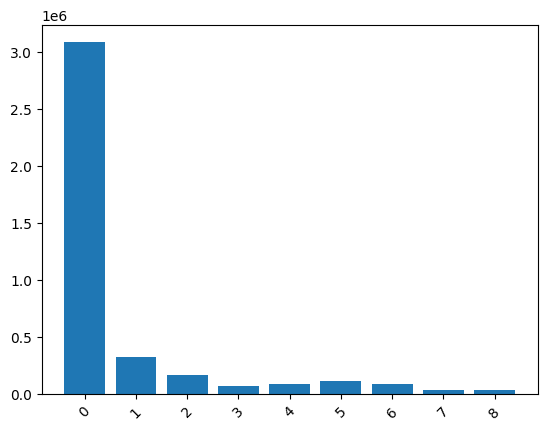

In [ ]:
bin_edges = [0, 5, 10, 20, 30, 50, 100, 200, 300]

def score_transform(scores):
    bin_indices = np.digitize(scores, bin_edges + [100000]) - 1
    return bin_indices

scores = np.array([int(d['score']) for d in data])
scores = score_transform(scores)

plt.bar(*np.unique(scores, return_counts=True))
plt.xticks(np.arange(len(bin_edges)), rotation=45)
plt.show()

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(bin_edges))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
processed_data = []
for d, s in zip(data, scores):
    processed_data.append({'text': d['title'], 'target': s})

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

dataset = datasets.Dataset.from_list(processed_data)
dataset = dataset.map(preprocess_function, batched=True)
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2)

Map: 100%|██████████| 4010957/4010957 [01:02<00:00, 64142.37 examples/s]


In [ ]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = transformers.TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: name 'evaluate' is not defined